In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt

In [291]:
## Parameters
CAL_INPUT_IMAGE_DIR = "camera_cal"
CAL_OUTPUT_FILE = "calibration_params.p"
TEST_IMAGE_DIR = "test_images"
S_THRESHOLD = (75, 255)
W_THRESHOLD = (225, 255)
B_THRESHOLD = (0, 35)
GRADIENT_X_THRESHOLD = (5, 100)
GRADIENT_Y_THRESHOLD = (0, 5000)
GRADIENT_MAG_THRESHOLD = (30, 100)
GRADIENT_DIR_THRESHOLD =(0.7, 1.3)

In [299]:
# Step 1: Calibrate camera, if not done before
class Utils:
    
    @staticmethod
    def calibrate_camera(image_dir, nx, ny, image_size):
        '''
        Compute and return camera calibration parameters
        '''
        
        if os.path.isfile(CAL_OUTPUT_FILE):
            print("Calibration has been done before, will skip!")
            cal_params = pickle.load( open( CAL_OUTPUT_FILE, "rb" ) )
            return cal_params
        else: 
            print("Needs calibration, proceeding...")
            objp = np.zeros((ny*nx, 3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []
            imgpoints = []

            images = glob.glob(os.path.join(image_dir, '*.jpg'))
            for ids, fname in enumerate(images):
                img = cv2.imread(fname)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret is True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            any_image = cv2.imread(images[0])
            img_size = (any_image.shape[1], any_image.shape[0])
            print("Image size is {}".format(img_size))
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            
            calibration_params = {}
            calibration_params["mtx"] = mtx
            calibration_params["dist"] = dist
            f = open (CAL_OUTPUT_FILE, "wb")
            pickle.dump(calibration_params, f)
            print("Camera calibration parameters written to {}".format(CAL_OUTPUT_FILE))
            return calibration_params

    @staticmethod
    def to_gray_scale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
    @staticmethod
    def gradient_x_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobelx = np.uint8(255 * (abs_sobelx/(np.max(abs_sobelx))))
        binary = np.zeros_like(scaled_sobelx)
        binary[(scaled_sobelx >= min_max[0]) & (scaled_sobelx <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def grad_y_threshold(gray_image, min_max):
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobely = np.uint8(255 * (abs_sobely/(np.max(abs_sobely))))
        binary = np.zeros_like(scaled_sobely)
        binary[(scaled_sobely >= min_max[0]) & (scaled_sobely <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def grad_mag_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=9)
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=9)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        grad_mg = np.sqrt(abs_sobelx**2 + abs_sobely**2) 
        scaled_grad_mag = np.uint8(255 * (grad_mg/(np.max(grad_mg))))
        binary = np.zeros_like(scaled_grad_mag)
        binary[(scaled_grad_mag > min_max[0]) & (scaled_grad_mag <= min_max[1])] = 1
        return binary
    
    @staticmethod
    def color_threshold(image, min_max):
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        channel_s = hls[:,:,2]
        binary = np.zeros_like(channel_s)
        binary[(channel_s >= min_max[0]) & (channel_s <=min_max[1])] = 1
        return binary
    
    @staticmethod
    def white_threshold(image, min_max):
        B,G,R = image[:,:,0],  image[:,:,1],  image[:,:,2]
        binary = np.zeros_like(B)
        binary[(B >= min_max[0]) & (B <=min_max[1]) & ((R >=min_max[0]) & (R <=min_max[1])) & ((G >=min_max[0]) & (G <=min_max[1]))] = 1
        return binary
    
    @staticmethod
    def black_threshold(image, min_max):
        B,G,R = image[:,:,0],  image[:,:,1],  image[:,:,2]
        binary = np.zeros_like(B)
        binary[(B >= min_max[0]) & (B <=min_max[1]) & ((R >=min_max[0]) & (R <=min_max[1])) & ((G >=min_max[0]) & (G <=min_max[1]))] = 1
        return binary
    
    @staticmethod
    def grad_dir_threshold(gray_image, min_max):
        sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = 15)
        sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = 15)
        angle = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary =  np.zeros_like(angle)
        binary[(angle >= min_max[0]) & (angle <= min_max[1])] = 1
        return binary 

    @staticmethod                       
    def get_perspective_src_dst_points(image):
        src_vertices = np.float32([[600, 450],[700, 450],[1120, 720],[200, 720]])
        dst_vertices = np.float32([[320,0],[950,0],[950,720],[320,720]])
        return (src_vertices, dst_vertices)
                        
    @staticmethod                       
    def histogram(image):
        return np.sum(image[image.shape[0]//2:,:], axis=0)

    @staticmethod
    def apply_thresholds(image):
        color_threshold_img    = Utils.color_threshold(image, S_THRESHOLD)
        white_threshold_img    = Utils.white_threshold(image, W_THRESHOLD)
        black_threshold_img    = Utils.black_threshold(image, B_THRESHOLD)
        gray = Utils.to_gray_scale(image)
        gradx_binary = Utils.gradient_x_threshold(gray, GRADIENT_X_THRESHOLD)
        grady_binary = Utils.grad_y_threshold(gray, GRADIENT_Y_THRESHOLD)
        mag_binary   = Utils.grad_mag_threshold(gray, GRADIENT_MAG_THRESHOLD)
        dir_binary   = Utils.grad_dir_threshold(gray, GRADIENT_DIR_THRESHOLD)
        combined = np.zeros_like(gray)
        #combined[(color_threshold_img == 1) & ((gradx_binary == 1) | ((mag_binary == 1) | (dir_binary == 1)))] = 1
        combined[ (black_threshold_img == 0) & (color_threshold_img == 1) & (gradx_binary == 1) | (white_threshold_img == 1)] = 1
        return combined
  
    @staticmethod
    def init_lane_polynomials(warped_binary):
        # build histogram
        histogram = Utils.histogram(warped_binary)
        out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255

        midpoint = np.int(histogram.shape[0]/2)
        # initialize x-locations for left and right lane
        leftx_base = np.argmax(histogram[0:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        n_windows = 9
        window_height = np.int(warped_binary.shape[0]/n_windows)
        non_zero = warped_binary.nonzero()
        non_zero_x = np.array(non_zero[0])
        non_zero_y = np.array(non_zero[1])
        
        left_x_current = leftx_base
        right_x_current = rightx_base
        margin = 100
        minpix = 50
        
        left_lane_inds = []
        right_lane_inds = []
        
        y_max = warped_binary.shape[0]
        x_max = warped_binary.shape[1]
        for window in range(n_windows):
            win_y_high = y_max - window * window_height
            win_y_low  = win_y_high - window_height
            
            win_xleft_low  = left_x_current - margin
            win_xleft_high = left_x_current + margin
            win_xright_low  = right_x_current - margin
            win_xright_high = right_x_current + margin
            
            cv2.rectangle(out_img, (win_xleft_low, win_y_low),  (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) & (non_zero_x < win_xleft_high)).nonzero()[0]
            good_right_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) & (non_zero_x < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                left_x_current = np.int(np.mean(non_zero_x[good_left_inds]))
            if len(good_right_inds) > minpix:
                right_x_current = np.int(np.mean(non_zero_x[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = non_zero_x[left_lane_inds]
        lefty = non_zero_y[left_lane_inds] 
        rightx = non_zero_x[right_lane_inds]
        righty = non_zero_y[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return left_fit, right_fit

    @staticmethod                              
    def find_lane_polynomials(warped_binary):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = warped_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return left_fit, right_fit
  
    @staticmethod
    def plot(image, left_fit, right_fit):
        # Generate x and y values for plotting
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    @staticmethod
    def plot_triplet(img1_with_title, img2_with_title, img3_with_title):
        if img1_with_title[2]:
            img1_with_title = (cv2.cvtColor(img1_with_title[0], cv2.COLOR_BGR2RGB), img1_with_title[1])
        if img2_with_title[2]:
            img2_with_title = (cv2.cvtColor(img2_with_title[0], cv2.COLOR_BGR2RGB), img2_with_title[1])
        if img3_with_title[2]:
            img3_with_title = (cv2.cvtColor(img3_with_title[0], cv2.COLOR_BGR2RGB), img2_with_title[1])
        
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
        f.tight_layout()
        ax1.imshow(img1_with_title[0])
        ax1.set_title(img1_with_title[1], fontsize=10)
        ax2.imshow(img2_with_title[0])
        ax2.set_title(img2_with_title[1], fontsize=10)
        ax3.imshow(img3_with_title[0])
        ax3.set_title(img3_with_title[1], fontsize=10)
   
    @staticmethod
    def plot_single(image, title, toRGB = False):
        plt.figure(figsize = (9,9))
        if toRGB:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image.squeeze())
        plt.title(title)

        


In [300]:
class Pipeline:
    
    
    def __init__(self):
        self.cal_mtx = None
        self.cal_dist = None
        self.pers_M = None
        self.target_width = None
        self.target_height = None
        self.calibration_done = False
        self.lanes_initialized = False
        self.nx = 9
        self.ny = 6
    
            
    def undistort(self, image):
        # calibrate camera if not done before
        if self.calibration_done is False:
            image_size = (image.shape[0], image.shape[1])
            cal_params = Utils.calibrate_camera(CAL_INPUT_IMAGE_DIR, self.nx, self.ny, image_size)
            self.cal_mtx = cal_params["mtx"]
            self.cal_dist = cal_params["dist"]
            self.calibration_done = True
        
        return cv2.undistort(image, self.cal_mtx, self.cal_dist, None, self.cal_mtx)      
    
    def warp_perspective(self, image):
        # evaluate perspective transformation matrix, if not done before
        if self.pers_M is None:
            src, dst = Utils.get_perspective_src_dst_points(image)
            self.pers_M = cv2.getPerspectiveTransform(src, dst)
        
        img_size = (image.shape[1], image.shape[0])
        warped_binary = cv2.warpPerspective(image, self.pers_M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        return warped_binary
    
    def find_lanes(self, warped_binary):
        # initialize left and right polynomials (for first image input)
        if self.lanes_initialized is False:
            left_fit, right_fit =  Utils.init_lane_polynomials(warped_binary)
            self.lanes_initialized = True
        else:
            left_fit, right_fit = Utils.find_lane_polynomials(warped_binary)
        return left_fit, right_fit  
              
    def process(self, image):
        undistorted = self.undistort(image)
        binary_thresholded = Utils.apply_thresholds(undistorted)
        warped = self.warp_perspective(binary_thresholded)
        self.find_lanes(warped)
        Utils.plot(image, self.left_fit, self.right_fit)
        return self.left_fit, self.right_fit
 

In [301]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [302]:
pipeline = Pipeline()
def process_image(image):
    return pipeline.process(image)

Populating the interactive namespace from numpy and matplotlib
Calibration has been done before, will skip!


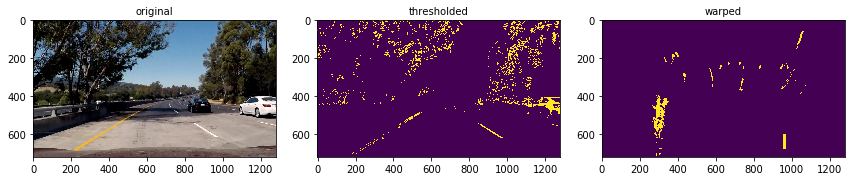

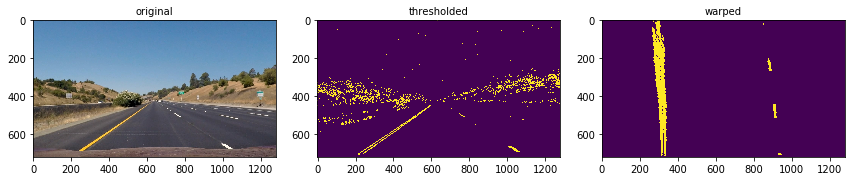

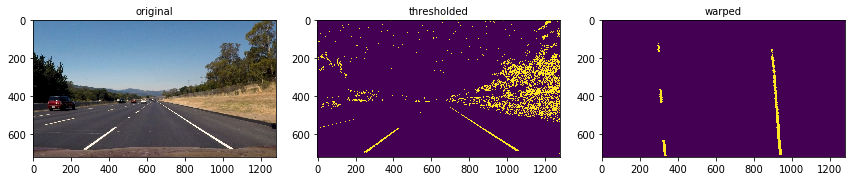

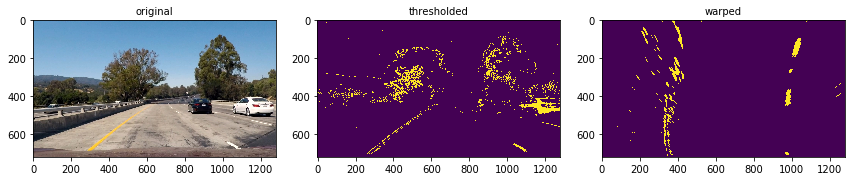

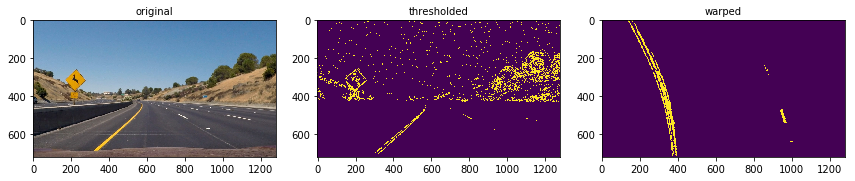

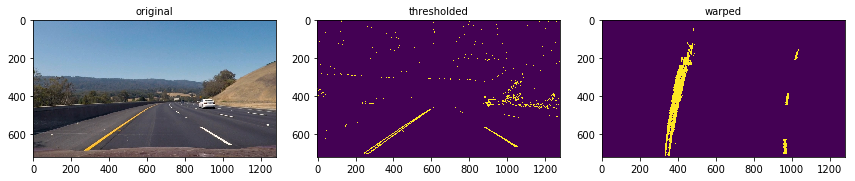

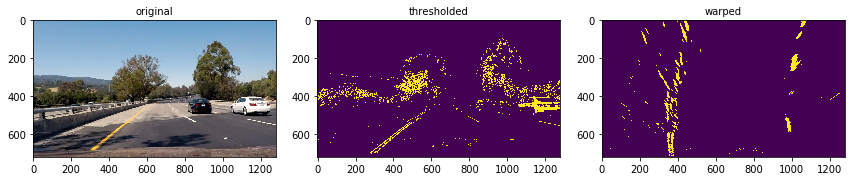

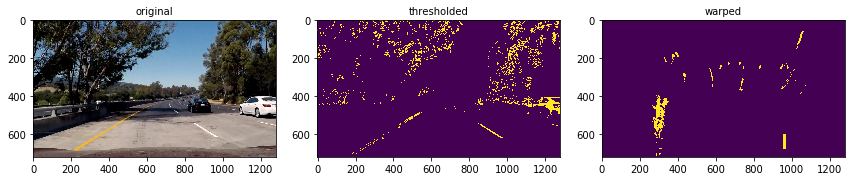

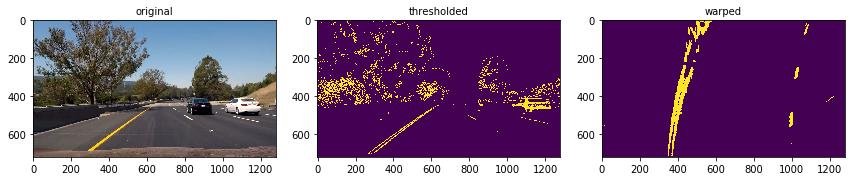

In [303]:
import os
import matplotlib.pyplot as plt
%pylab inline

test_images = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg'))

for test_image_path in test_images:
    test_image = cv2.imread(test_image_path)
    #Utils.plot_single(test_image, "original", True)
    undistorted = pipeline.undistort(test_image)
    #Utils.plot_single(undistorted, "undistorted", True)

    binary_thresholded = Utils.apply_thresholds(undistorted)
    #Utils.plot_single(binary_thresholded, "thresholded")

    warped = pipeline.warp_perspective(binary_thresholded)
    #Utils.plot_single(warped, "warped")
    Utils.plot_triplet((test_image, "original", True), (binary_thresholded, "thresholded", False), (warped, "warped", False))
    
    #lanes = pipeline.find_lanes(warped)
    #print("lanes {}".format(lanes))

#self.find_lanes(warped)

#pipeline(test_image)
plt.show()
#plt.close()

In [ ]:
import os
challenge_input = 'challenge_video.mp4'
#output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(challenge_input)
output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)